### using ARIMA and Seasonal ARIMA
The general process for ARIMA models is the following:

Visualize the Time Series Data                                                     
Make the time series data stationary                                                     
Plot the Correlation and AutoCorrelation Charts                                               
Construct the ARIMA Model or Seasonal ARIMA based on the data                                  
Use the model to make predictions                                  

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [2]:
df=pd.read_excel('chk.xlsx')

In [3]:
df.head()

,Year,Rate
0,201001,5.55
1,201002,5.74
2,201003,5.99
3,201004,6.24
4,201005,6.65


In [4]:
df.tail()

,Year,Rate
104,201809,5.30
105,201810,5.35
106,201811,5.35
107,201812,5.35
108,201901,5.35


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    109 non-null    int64  
 1   Rate    109 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 1.8 KB


In [6]:
df.isnull().sum()

Year    0
Rate    0
dtype: int64

In [7]:
df.describe()

,Year,Rate
count,109.000000,109.000000
mean,201411.036697,5.996239
std,262.529960,0.925182
min,201001.000000,5.090000
25%,201204.000000,5.350000
50%,201407.000000,5.530000
75%,201610.000000,6.650000
max,201901.000000,7.790000


In [8]:
df.shape

(109, 2)

# Preparing the Data

In [9]:
df['Year']=pd.to_datetime(df['Year'],format='%Y%m')

In [10]:
df.set_index('Year', inplace=True)

In [11]:
df.head()

,Rate
Year,
2010-01-01,5.55
2010-02-01,5.74
2010-03-01,5.99
2010-04-01,6.24
2010-05-01,6.65


# Examine the Data

Now we take a look at the data.

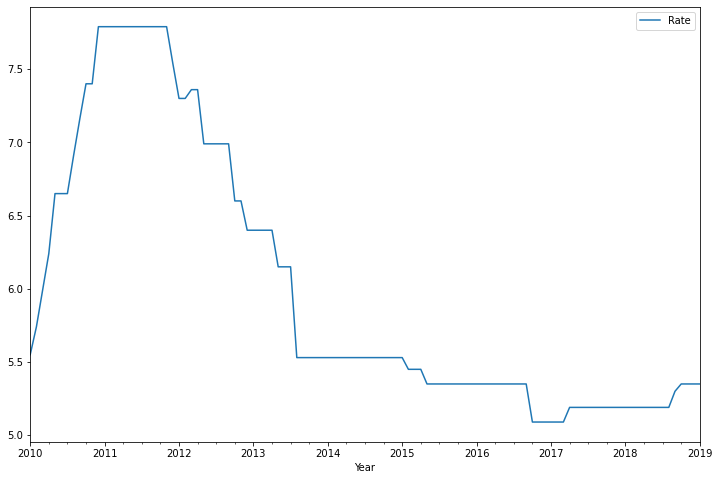

In [12]:
# show plots in the notebook
%matplotlib inline
df.plot(figsize=(12,8));

In [13]:
sm.stats.durbin_watson(df)

array([0.0004181])

The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation

In [14]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [15]:
test_result=adfuller(df['Rate'])

In [16]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Rate):
    result=adfuller(Rate)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [17]:
adfuller_test(df['Rate'])

ADF Test Statistic : -3.334796431600455
p-value : 0.013392936534320957
#Lags Used : 10
Number of Observations Used : 98
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [18]:
df['Rate First Difference'] = df['Rate'] - df['Rate'].shift(1)

In [19]:
df['Rate'].shift(1).head()

Year
2010-01-01     NaN
2010-02-01    5.55
2010-03-01    5.74
2010-04-01    5.99
2010-05-01    6.24
Name: Rate, dtype: float64

In [20]:
df['Seasonal First Difference']=df['Rate']-df['Rate'].shift(12)

In [21]:
df.head(10)

,Rate,Rate First Difference,Seasonal First Difference
Year,,,
2010-01-01,5.55,NaN,NaN
2010-02-01,5.74,0.19,NaN
2010-03-01,5.99,0.25,NaN
2010-04-01,6.24,0.25,NaN
2010-05-01,6.65,0.41,NaN
2010-06-01,6.65,0.00,NaN
2010-07-01,6.65,0.00,NaN
2010-08-01,6.91,0.26,NaN
2010-09-01,7.16,0.25,NaN


In [22]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -1.6675693098825748
p-value : 0.4478944029930399
#Lags Used : 12
Number of Observations Used : 84
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<AxesSubplot:xlabel='Year'>

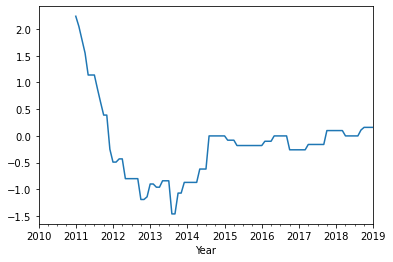

In [23]:
df['Seasonal First Difference'].plot()

In [24]:
## Again test dickey fuller test
adfuller_test(df['Rate First Difference'].dropna())

ADF Test Statistic : -8.118987391568075
p-value : 1.1698956190715269e-12
#Lags Used : 0
Number of Observations Used : 107
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Year'>

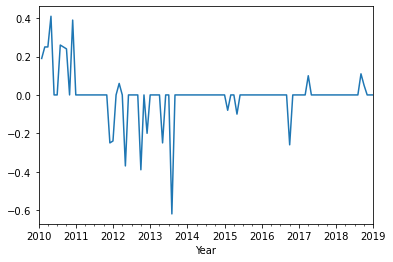

In [25]:
df['Rate First Difference'].plot()

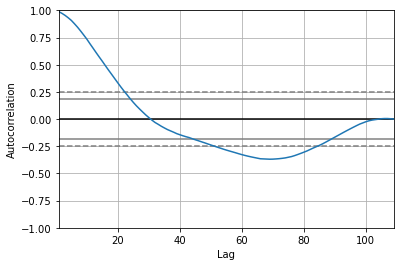

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Rate'])
plt.show()

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

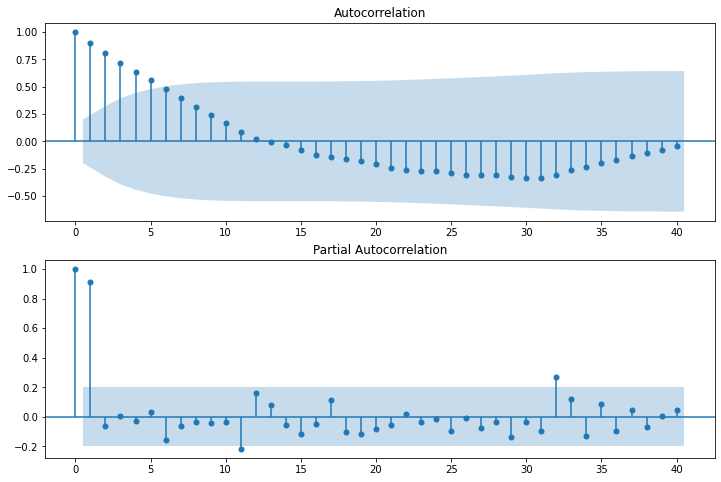

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[12:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[12:],lags=40,ax=ax2)

In [29]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [30]:
model=ARIMA(df['Rate'],order=(1,1,1))
model_fit=model.fit()

In [31]:
model_fit.aic

-155.03354978091488

In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Rate   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  81.517
Method:                       css-mle   S.D. of innovations              0.113
Date:                Mon, 08 Feb 2021   AIC                           -155.034
Time:                        18:37:28   BIC                           -144.305
Sample:                    02-01-2010   HQIC                          -150.684
                         - 01-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0278      0.055      0.510      0.610      -0.079       0.135
ar.L1.D.Rate     0.9618      0.039     24.928      0.000       0.886       1.037
ma.L1.D.Rate    -0.7977      0.062    -12.822      0.000      -0.920      -0.676
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0397           +0.0000j            1.0397            0.0000
MA.1            1.2536           +0.0000j            1.2536            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Year'>

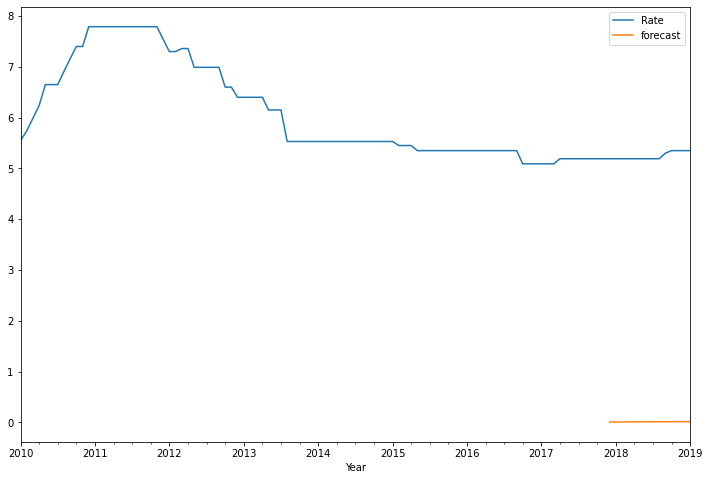

In [33]:
df['forecast']=model_fit.predict(start=95,end=108,dynamic=True)
df[['Rate','forecast']].plot(figsize=(12,8))

In [34]:
model=sm.tsa.statespace.SARIMAX(df['Rate'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
predict_rate=results.predict(start=95,end=108,dynamic=True)
print(predict_rate)

In [ ]:
df['forecast']=results.predict(start=90,end=108,dynamic=True)
df[['Rate','forecast']].plot(figsize=(12,8))

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [ ]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [ ]:
future_datest_df.tail()

In [ ]:
future_df=pd.concat([df,future_datest_df])

In [ ]:
future_df['forecast'] = results.predict(start =107, end = 132, dynamic= True)  
future_df[['Rate', 'forecast']].plot(figsize=(12, 8)) 

In [ ]:
future_df.tail(12)

## Calculate Forecast Errors

#### Mean absolute error:
The mean absolute error (MAE) value is computed as the average absolute error value. If this value is 0 (zero), the fit (forecast) is perfect. As compared to the mean squared error value, this measure of fit will “de-emphasize” outliers, that is, unique or rare large error values will affect the MAE less than the MSE value.

#### Mean Forecast Error (Bias).
The mean forecast error (MFE) is the average error in the observations. A large positive MFE means that the forecast is undershooting the actual observations, and a large negative MFE means the forecast is overshooting the actual observations. A value near zero is ideal.

The MAE is a better indicator of fit than the MFE.

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100

In [ ]:
print("MFE = ", mean_forecast_err(df.Rate, predict_rate))
print("MAE = ", mean_absolute_err(df.Rate, predict_rate))

For MFE > 0, models tends to under-forecast. However, as long as the tracking signal is between –4 and 4, we assume the model is working correctly. The measure of MAE being small would indicate a pretty good fit